<a href="https://colab.research.google.com/github/cchen744/CornYield_NN/blob/geo/yield_prediction%2Bgeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import geopandas as gpd

(Optional) Get datasets from Github

In [4]:
# Access github repo
REPO_URL = "https://github.com/cchen744/CornYield_NN.git"
REPO_NAME = "CornYield_NN" # This is the folder name that will be created

# 4. Clone the repository
# We use the token for secure, authenticated access
!git clone https://github.com/cchen744/CornYield_NN.git

# 5. Change the working directory into the cloned repository folder
import os
os.chdir(REPO_NAME)

# Verify the files are there (you should see your notebook and dataset files)
print(f"Current directory contents in /{REPO_NAME}:")
!ls -F

Cloning into 'CornYield_NN'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 67 (delta 31), reused 30 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 3.53 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Current directory contents in /CornYield_NN:
counties.csv		     prism_weather_1995-2009.csv  weather_clean.csv
final_dataset.csv	     prism_weather_2010-2024.csv  wide_data.csv
get_data.ipynb		     prism_weather.csv		  yield_clean.csv
LSTM_+_MLP_model.ipynb	     RandomForest.ipynb		  yield.csv
nasa_weather.csv	     soil_clean.csv
prism_weather_1984-1994.csv  soil_data.csv


#Dataset preparation

We have 3 types of datasets:
1. yield data, which looks like: <br>
Year, County, Yield
2. monthly weather data, which looks like: <br>
County, Year, Month, solar_radiation, humidity, ...., vpd_max
3. soil dataset: <br>
County, bdod, cec, ....

In [5]:
# Load 3 datasets
yield_df_path = "/content/CornYield_NN/yield_clean.csv"
soil_df_path = "/content/CornYield_NN/soil_clean.csv"
weather_df_path = "/content/CornYield_NN/weather_clean.csv"
yield_df = pd.read_csv(yield_df_path)
soil_df = pd.read_csv(soil_df_path)
weather_df = pd.read_csv(weather_df_path)
print(yield_df.head())
print(soil_df.head())
print(weather_df.head())

   Year      County  Yield
0  2024       adams  120.1
1  2024  green lake  168.3
2  2024      juneau  141.0
3  2024   marquette  126.0
4  2024     portage  159.5
     County  bdod  cec  clay  nitrogen  phh2o  sand  silt  soc
0     adams   132  163   192       698     60   489   319  375
1   ashland   115  249   258       601     51   216   526  605
2    barron   133  150   185       516     55   317   498  677
3  bayfield   111  266   187       545     50   480   333  668
4     brown   134  289   308       781     66   328   364  429
  County  Year  Month  solar_radiation  humidity  wind_speed  wind_speed_max  \
0  adams  1984      4            16.85     75.80        4.40           12.36   
1  adams  1984      5            17.63     74.25        3.26            9.64   
2  adams  1984      6            20.75     78.96        3.42            9.15   
3  adams  1984      7            21.90     74.48        2.68            8.19   
4  adams  1984      8            18.52     68.76        2.31

We want the dataset to have the format:<br>
(batch_size,num_months,num_features)

In [ ]:
# prepare monthly sequences

# Select monthly columns for LSTM
monthly_features = weather_df.columns[3:]
# Sort and group monthly dataset by (County, Year)
grouped_weather = (weather_df
    .sort_values(["County", "Year", "Month"])
    .groupby(["County", "Year"])
)

# Build dictionary: key = (county, year), value = monthly sequence array
monthly_weather_dict = {}

for (county, year), g in grouped_weather:
    seq = g[monthly_features].values  # shape = (num_months, num_features)
    monthly_weather_dict[(county, year)] = seq

# Show an example
first_key = list(monthly_weather_dict.keys())[0]
print("Example key:", first_key)
print("Sequence shape:", monthly_weather_dict[first_key].shape)
print(monthly_weather_dict[first_key][:3])  # first 3 months


Example key: ('adams', np.int64(1984))
Sequence shape: (6, 11)
[[16.85 75.8   4.4  12.36  3.83 35.5  46.5  57.5  29.7   1.57 10.85]
 [17.63 74.25  3.26  9.64  2.27 41.4  53.7  65.9  40.2   1.12 13.4 ]
 [20.75 78.96  3.42  9.15  5.96 56.2  68.1  80.   57.    1.2  18.43]]


Train test split

In [ ]:
# Original
"""
# Find all (county, year) pairs with yield + weather keys, store keys in a list
all_keys = list(monthly_weather_dict.keys())
# Perform train_test_split on key_list
train_keys, test_keys = train_test_split(all_keys, test_size=0.2, random_state=42)
"""

'\n# Find all (county, year) pairs with yield + weather keys, store keys in a list\nall_keys = list(monthly_weather_dict.keys())\n# Perform train_test_split on key_list\ntrain_keys, test_keys = train_test_split(all_keys, test_size=0.2, random_state=42)\n'

In [ ]:
# UPDATE skip data that is not present in both yield and weather

# Get all (county, year) pairs from monthly_weather_dict
all_weather_keys = set(monthly_weather_dict.keys())

# Ensure 'Year' column in yield_df is np.int64 to match weather_dict keys
yield_df['Year'] = yield_df['Year'].astype(np.int64)

# Get all (county, year) pairs from yield_df with consistent Year type
all_yield_keys = set(tuple(row) for row in yield_df[['County', 'Year']].values)

# Find the intersection of keys (only keep pairs that have both weather and yield data)
all_keys = list(all_weather_keys.intersection(all_yield_keys))

# Perform train_test_split on key_list
train_keys, test_keys = train_test_split(all_keys, test_size=0.2, random_state=42)

In [ ]:
# UPDATE fixed issue with incorrect datatypes and assignments
# Dataset preparations -- GitHub
# Added: dataset normalization
class NormalizedYieldDataset(Dataset):
    def __init__(self, keys, yield_df, soil_df, weather_dict,
                 weather_scaler=None, soil_scaler=None, yield_scaler=None,
                 fit_scalers=False):
        self.keys = keys
        self.yield_df = yield_df
        self.soil_df = soil_df
        self.weather_dict = weather_dict

        # initialize scalers
        if fit_scalers:
            # Fit weather scaler
            all_weather = np.vstack([weather_dict[k] for k in keys])
            self.weather_scaler = StandardScaler()
            self.weather_scaler.fit(all_weather)

            # Fit soil scaler
            soil_counties = [k[0] for k in keys]
            soil_data = soil_df[soil_df['County'].isin(soil_counties)].drop('County', axis=1).values
            self.soil_scaler = StandardScaler()
            self.soil_scaler.fit(soil_data)

            # Fit yield scaler
            yield_data = []
            for county, year in keys:
                y = yield_df[(yield_df["County"]==county) & (yield_df["Year"]==year)]["Yield"].values[0]
                yield_data.append(y)
            self.yield_scaler = StandardScaler()
            self.yield_scaler.fit(np.array(yield_data).reshape(-1, 1))
        else:
            self.weather_scaler = weather_scaler
            self.soil_scaler = soil_scaler
            self.yield_scaler = yield_scaler

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        county, year = self.keys[idx]

        # Get and normalize weather
        weather_seq = self.weather_dict[(county, year)]
        weather_seq = self.weather_scaler.transform(weather_seq)
        weather_seq = torch.tensor(weather_seq, dtype=torch.float32)

        # Get and normalize yield
        y = self.yield_df[
            (self.yield_df["County"]==county) &
            (self.yield_df["Year"]==year)]["Yield"].values[0]
        y_normalized = self.yield_scaler.transform([[y]])[0]

        # Get and normalize soil
        soil_row = self.soil_df[self.soil_df["County"] == county].iloc[0]
        soil_vec = soil_row.drop("County").values.astype(np.float32)
        soil_vec = self.soil_scaler.transform([soil_vec])[0]
        soil_vec = torch.tensor(soil_vec, dtype=torch.float32)

        return weather_seq, soil_vec, torch.tensor(y_normalized, dtype=torch.float32)


In [ ]:
# Create DataLoader
batch_size = 32
# create datasets
train_dataset = NormalizedYieldDataset(
    train_keys, yield_df, soil_df, monthly_weather_dict,
    fit_scalers=True
)

test_dataset = NormalizedYieldDataset(
    test_keys, yield_df, soil_df, monthly_weather_dict,
    weather_scaler=train_dataset.weather_scaler,
    soil_scaler=train_dataset.soil_scaler,
    yield_scaler=train_dataset.yield_scaler,
    fit_scalers=False
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Architecture

In [ ]:
# Model
# Model assumes that there is at least 1 dimension in monthly, and static
class YieldLSTMMLPConnected(nn.Module):
    def __init__(self,
                    monthly_dim=11,     # Avg's by month (seq features, should be 11 features from weather_clean.csv)
                    monthly_layers=1,
                    monthly_hidden=64,
                    static_dim=8,    # number of static features (should be 8 features from soil data)
                    static_hidden=32,
                    head_hidden=64,
                    output_dim=1,
                    dropout=0.1
                    ):
        super().__init__()

        # Monthly branch LSTM
        self.lstm = nn.LSTM(
            input_size=monthly_dim,
            hidden_size=monthly_hidden,
            num_layers=monthly_layers,
            batch_first=True,
            bidirectional=False
        )
        self.monthly_proj = nn.Sequential(
            nn.Linear(monthly_hidden, monthly_hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )


        # Static branch MLP
        self.static_proj = nn.Sequential(
            nn.Linear(static_dim, static_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(static_hidden, static_hidden),
            nn.ReLU(),
        )

        # Combined head (output of combined branches)
        combined_dim = monthly_hidden + static_hidden
        self.head = nn.Sequential(
            nn.Linear(combined_dim, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, head_hidden//2),
            nn.ReLU(),
            nn.Linear(head_hidden//2, output_dim)
        )

    def forward(self, weather_seq, static):
        feats = []

        # Monthly shape (batch, seq_len, monthly_dim)
        # LSTM: take last hidden state
        lstm_out, (h_n, c_n) = self.lstm(weather_seq)
        # h_n shape: (num_layers, batch, hidden)
        last_h = h_n[-1] # (batch, monthly_hidden)
        monthly_emb = self.monthly_proj(last_h)
        feats.append(monthly_emb)

        feats.append(self.static_proj(static))

        combined = torch.cat(feats, dim=1)
        out = self.head(combined)
        return out

## Training

In [ ]:
# UPDATE removed yearly in for loops within train_loader
# Training
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=1e-3,
    weight_decay=1e-5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    early_stop_patience=8
):

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(1, num_epochs+1):
        # -------- TRAIN MODE --------
        model.train()
        train_losses = []

        for monthly, static, target in train_loader: # UPDATE removed yearly
            monthly = monthly.to(device)
            static = static.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            preds = model(monthly, static) # UPDATE removed yearly

            loss = criterion(preds, target)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # -------- VAL MODE --------
        model.eval()
        val_losses = []

        with torch.no_grad():
            for monthly, static, target in val_loader: # UPDATE removed yearly
                monthly = monthly.to(device)
                static = static.to(device)
                target = target.to(device)

                preds = model(monthly, static) # UPDATE removed yearly
                loss = criterion(preds, target)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # ---- EARLY STOP ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_yield_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

    print("Training completed. Best model saved as best_yield_model.pt")

## Model Evaluation

### Load Best Model

In [ ]:
# Run Testing
model = YieldLSTMMLPConnected()
train_model(model, train_loader, test_loader)

Epoch 001 | Train Loss: 0.8216 | Val Loss: 0.5516
Epoch 002 | Train Loss: 0.4553 | Val Loss: 0.4001
Epoch 003 | Train Loss: 0.3890 | Val Loss: 0.3499
Epoch 004 | Train Loss: 0.3613 | Val Loss: 0.3553
Epoch 005 | Train Loss: 0.3595 | Val Loss: 0.3298
Epoch 006 | Train Loss: 0.3212 | Val Loss: 0.3315
Epoch 007 | Train Loss: 0.3079 | Val Loss: 0.2823
Epoch 008 | Train Loss: 0.2863 | Val Loss: 0.2873
Epoch 009 | Train Loss: 0.2806 | Val Loss: 0.2551
Epoch 010 | Train Loss: 0.2544 | Val Loss: 0.2364
Epoch 011 | Train Loss: 0.2480 | Val Loss: 0.2487
Epoch 012 | Train Loss: 0.2330 | Val Loss: 0.2177
Epoch 013 | Train Loss: 0.2299 | Val Loss: 0.2505
Epoch 014 | Train Loss: 0.2158 | Val Loss: 0.2037
Epoch 015 | Train Loss: 0.1943 | Val Loss: 0.2000
Epoch 016 | Train Loss: 0.1909 | Val Loss: 0.2266
Epoch 017 | Train Loss: 0.1903 | Val Loss: 0.1987
Epoch 018 | Train Loss: 0.1879 | Val Loss: 0.1932
Epoch 019 | Train Loss: 0.1830 | Val Loss: 0.2079
Epoch 020 | Train Loss: 0.1742 | Val Loss: 0.1819


### Real-Scale Performance Metrics

In [ ]:
def evaluate_real_performance(model, test_loader, yield_scaler, device='cuda'):
    """denormalization to check the real performance"""
    model.eval()
    model = model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for monthly, static, target in test_loader:
            monthly = monthly.to(device)
            static = static.to(device)

            preds = model(monthly, static)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(target.cpu().numpy())

    # concatenate all batches
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # denormalization
    preds_original = yield_scaler.inverse_transform(all_preds)
    targets_original = yield_scaler.inverse_transform(all_targets)

    # calculate real error
    mae = np.mean(np.abs(preds_original - targets_original))
    rmse = np.sqrt(np.mean((preds_original - targets_original)**2))
    mape = np.mean(np.abs((preds_original - targets_original) / targets_original)) * 100
    r2 = r2_score(targets_original, preds_original)

    # normalized RMSE
    normalized_rmse = rmse / np.std(targets_original)

    print("\n" + "="*70)
    print("FINAL MODEL PERFORMANCE (Real Scale - Bushels/Acre)")
    print("="*70)
    print(f"Mean Absolute Error (MAE):        {mae:.2f} bushels/acre")
    print(f"Root Mean Squared Error (RMSE):   {rmse:.2f} bushels/acre")
    print(f"Mean Absolute Percentage Error:   {mape:.2f}%")
    print(f"R² Score:                         {r2:.4f}")
    print("="*70)

    # context information of raw data
    print("\nContext:")
    print(f"Average yield in test set:        {np.mean(targets_original):.2f} bushels/acre")
    print(f"Std deviation in test set:        {np.std(targets_original):.2f} bushels/acre")
    print(f"Normalized RMSE (RMSE/std):       {rmse/np.std(targets_original):.4f}")
    print(f"Prediction range:                 [{preds_original.min():.1f}, {preds_original.max():.1f}]")
    print(f"Actual range:                     [{targets_original.min():.1f}, {targets_original.max():.1f}]")

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2,
        'preds': preds_original, 'targets': targets_original,
        'normalized_rmse': normalized_rmse
    }

# load the best model
best_model = YieldLSTMMLPConnected()
best_model.load_state_dict(torch.load("best_yield_model.pt", map_location="cpu"))
best_model.to("cpu")

# evaluation
results = evaluate_real_performance(best_model, test_loader, train_dataset.yield_scaler,device='cpu')


FINAL MODEL PERFORMANCE (Real Scale - Bushels/Acre)
Mean Absolute Error (MAE):        9.19 bushels/acre
Root Mean Squared Error (RMSE):   11.94 bushels/acre
Mean Absolute Percentage Error:   8.09%
R² Score:                         0.8638

Context:
Average yield in test set:        128.88 bushels/acre
Std deviation in test set:        32.34 bushels/acre
Normalized RMSE (RMSE/std):       0.3691
Prediction range:                 [57.6, 204.2]
Actual range:                     [37.6, 211.4]


In [ ]:
# Normalized RMSE = RMSE / Standard Deviation
# This metric accounts for data variability
normalized_rmse = results['normalized_rmse']

if normalized_rmse < 0.5:
    print("Excellent: Model explains >75% variance")
elif normalized_rmse < 0.7:
    print("Good: Model explains >50% of variance")
elif normalized_rmse < 1.0:
    print("Fair: Model performs better than simple averaging")
else:
    print("Poor: Model performs worse than averaging predictions")

Excellent: Model explains >75% variance


### Baseline Comparison

In [ ]:
# TODO: Compare your results with the RF baseline

print("MODEL COMPARISON")

# Your results (from above)
your_rmse = results['rmse']
your_r2 = results['r2']

# RF results
rf_rmse = np.sqrt(154.52) # RF baseline RMSE
rf_r2 = 0.84    # RF baseline R²

# Calculate improvement
improvement_rmse = (rf_rmse - your_rmse) / rf_rmse * 100
improvement_r2 = (your_r2 - rf_r2) / rf_r2 * 100

print(f"Random Forest Baseline:  RMSE = {rf_rmse:.2f}, R² = {rf_r2:.4f}")
print(f'Your LSTM+MLP Model:     RMSE = {your_rmse:.2f}, R² = {your_r2:.4f}')
print(f'\n Improvement:')
print(f'  RMSE: {improvement_rmse:+.1f}% { 'T' if improvement_rmse > 0 else 'F'}')
print(f'  R²:   {improvement_r2:+.1f}% { 'T' if improvement_r2 > 0 else 'F'}')

# Evaluation
if improvement_rmse > 10:
    print('\n Conclusion: The deep learning model significantly outperforms RF and is worth using!')
elif improvement_rmse > 5:
    print("\n Conclusion: Deep learning model shows improvement, worth considering")
elif improvement_rmse > 0:
    print('\n Conclusion: Minimal gain, may not justify added complexity')
else:
    print('\n Conclusion: RF performs better, consider refining deep learning model or using RF')


MODEL COMPARISON
Random Forest Baseline:  RMSE = 12.43, R² = 0.8400
Your LSTM+MLP Model:     RMSE = 11.94, R² = 0.8638

 Improvement:
  RMSE: +4.0% T
  R²:   +2.8% T

 Conclusion: Minimal gain, may not justify added complexity


### Visualization

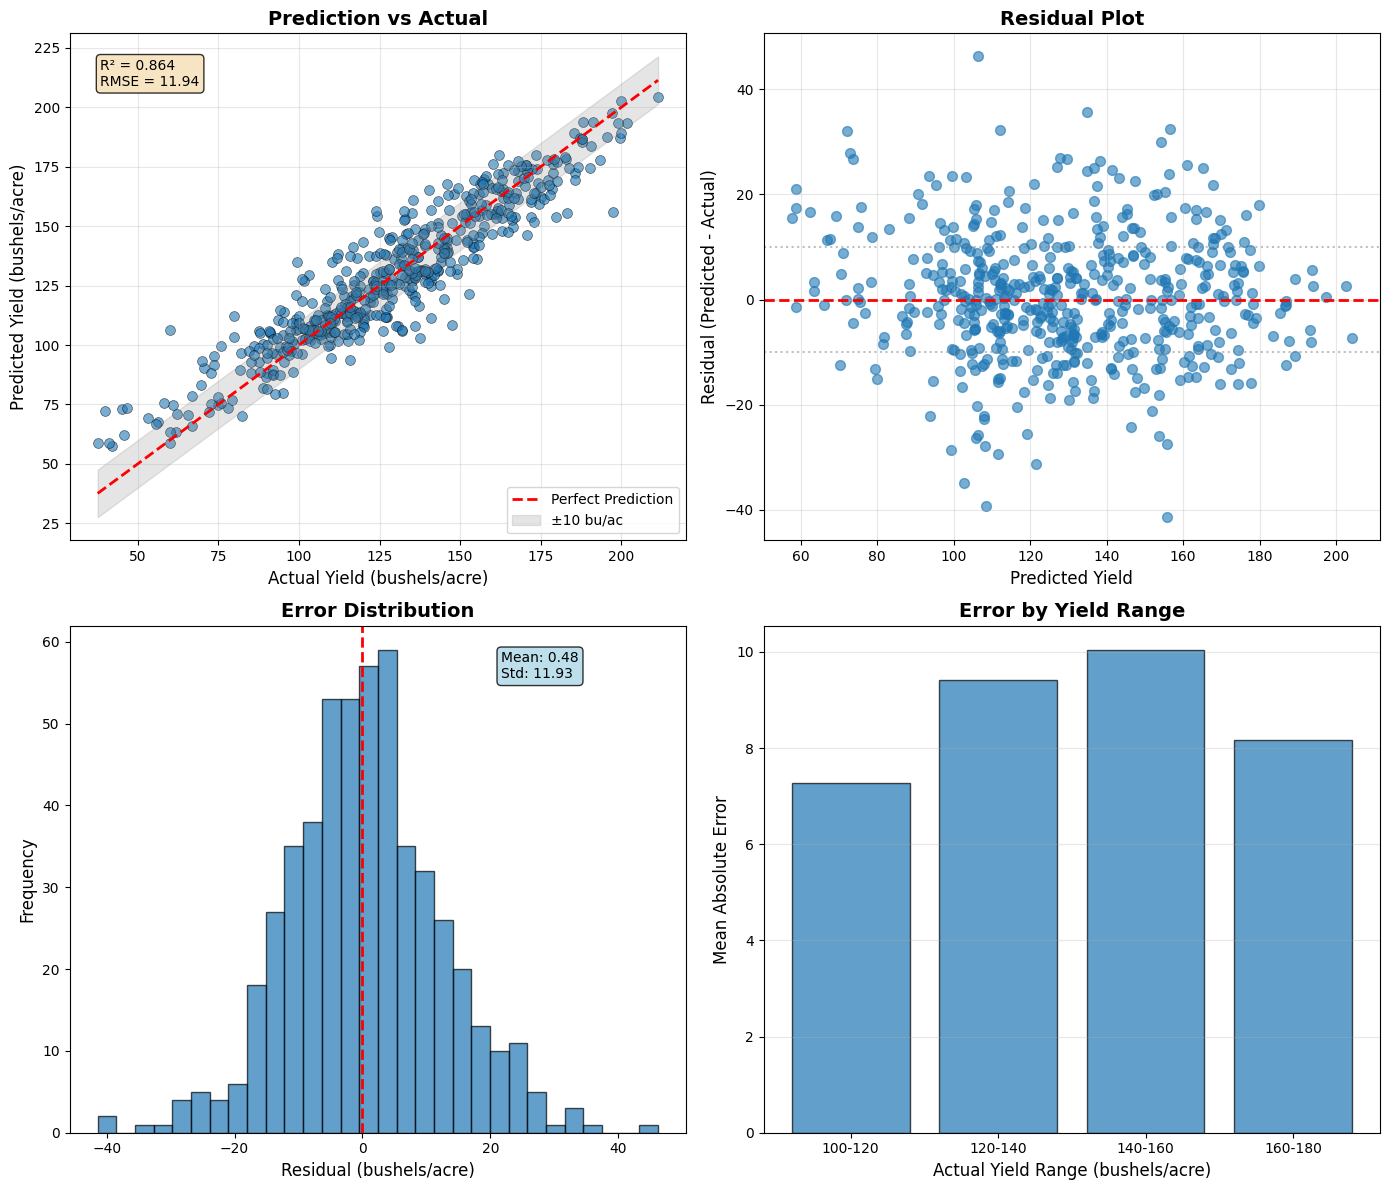

In [ ]:
def visualize_results(results):
    """create complete visualization"""
    preds = results['preds'].flatten()
    targets = results['targets'].flatten()

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # 1. Prediction vs Actual
    ax = axes[0, 0]
    ax.scatter(targets, preds, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # ±10 bushels error band
    ax.fill_between([min_val, max_val], [min_val-10, max_val-10], [min_val+10, max_val+10],
                     color='gray', alpha=0.2, label='±10 bu/ac')

    ax.set_xlabel('Actual Yield (bushels/acre)', fontsize=12)
    ax.set_ylabel('Predicted Yield (bushels/acre)', fontsize=12)
    ax.set_title('Prediction vs Actual', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add R² text
    ax.text(0.05, 0.95, f"R² = {results['r2']:.3f}\nRMSE = {results['rmse']:.2f}",
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 2. Residual plot
    ax = axes[0, 1]
    residuals = preds - targets
    ax.scatter(preds, residuals, alpha=0.6, s=50)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.axhline(y=10, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(y=-10, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Predicted Yield', fontsize=12)
    ax.set_ylabel('Residual (Predicted - Actual)', fontsize=12)
    ax.set_title('Residual Plot', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # 3. Error distribution
    ax = axes[1, 0]
    ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Residual (bushels/acre)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Error Distribution', fontsize=14, fontweight='bold')

    # Add stats
    ax.text(0.70, 0.95, f"Mean: {np.mean(residuals):.2f}\nStd: {np.std(residuals):.2f}",
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # 4. Prediction accuracy by range
    ax = axes[1, 1]

    # Bin predictions by actual yield
    bins = [100, 120, 140, 160, 180]
    bin_labels = ['100-120', '120-140', '140-160', '160-180']
    bin_errors = []

    for i in range(len(bins)-1):
        mask = (targets >= bins[i]) & (targets < bins[i+1])
        if mask.sum() > 0:
            bin_errors.append(np.abs(residuals[mask]).mean())
        else:
            bin_errors.append(0)

    ax.bar(bin_labels, bin_errors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Actual Yield Range (bushels/acre)', fontsize=12)
    ax.set_ylabel('Mean Absolute Error', fontsize=12)
    ax.set_title('Error by Yield Range', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_results(results)

## Spatial-Temporal Analysis

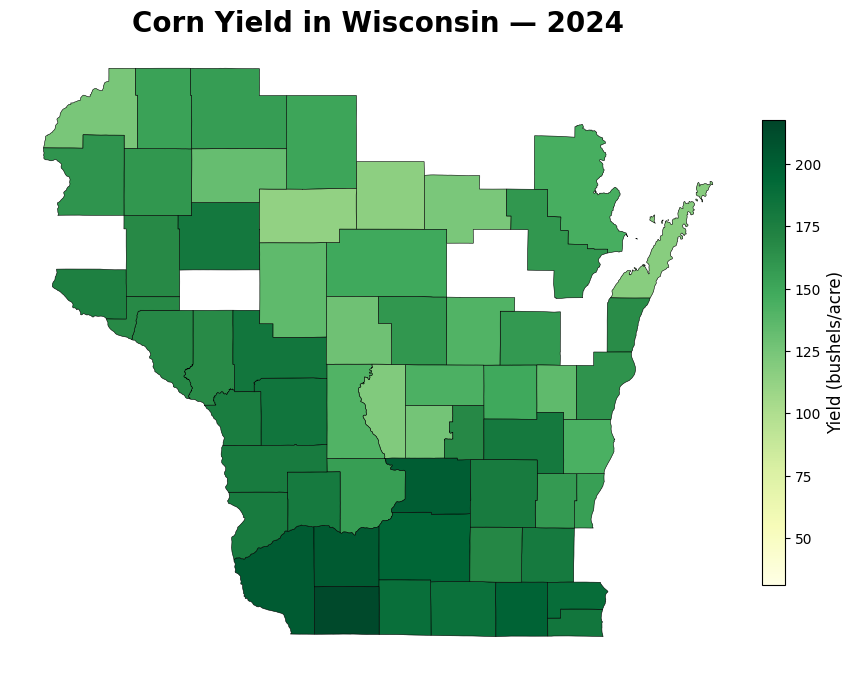

In [22]:
# Wisconsin corn map
def create_yield_animation(yield_df, wi_counties):
    """
    Animate corn yield across Wisconsin counties over years.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    years = sorted(yield_df['Year'].unique())


    vmin = yield_df['Yield'].min()
    vmax = yield_df['Yield'].max()


    cmap = plt.cm.YlGn
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []

    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Yield (bushels/acre)", fontsize=12)

    def update(year):
        ax.clear()

        # Merge
        year_data = yield_df[yield_df['Year'] == year]
        merged = wi_counties.merge(year_data, on='County', how='left')

        # Plot
        merged.plot(
            column="Yield",
            cmap="YlGn",
            edgecolor="black",
            linewidth=0.4,
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            legend=False
        )

        ax.set_title(f"Corn Yield in Wisconsin — {year}", fontsize=20, fontweight="bold")
        ax.axis("off")

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=years,
        interval=700,
        repeat=True
    )

    ani.save("yield_spatiotemporal.gif", writer="pillow", fps=2)
    plt.show()



wi_counties = gpd.read_file("https://raw.githubusercontent.com/mhaffner/data/master/wi_counties.geojson")
wi_counties = wi_counties.rename(columns={"NAME": "County"})
wi_counties['County'] = wi_counties['County'].str.lower()



create_yield_animation(yield_df, wi_counties)
